# Starbucks Capstone Project

This is the main script of the capstone project for the Udacity Data Science Nano-Degree (Jan 2020 Cohort).

The goal of this work is to investigate the data provided, then predict if someone will respond to an offer based on the type of offer provided (channel, offer type, difficulty, etc). The outcome of this project will be a machine learning model predicting if the average spend of an individual during an offer will be higher than their un-influenced average spend. 

I chose not to do a reccomender system as there are many potential combinations of types of channels, offer types, and difficulty/rewards. With the goal to not limit this exercise to only the existing short portfolio - the model produced could help tailor future offers that do not yet exist.

Note: an attempt was made to perform the below with a regression (to predict the a float for the impact of the offer, rather than a binary), however more time would be needed to explore methods to improve accuracy. At this point, the time limitations of the course require an immediate submission. 


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as pyplot
from functions import *

In [2]:
# import datasets and clean portfolio dataset
portfolio, profile, transcript = import_data()
portfolio = clean_portfolio(portfolio)
portfolio.head()

reward  difficulty  duration                                id  social  \
0      10          10         7  ae264e3637204a6fb9bb56bc8210ddfd       1   
1      10          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0       1   
2       0           0         4  3f207df678b143eea3cee63160fa8bed       0   
3       5           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9       0   
4       5          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7       0   

   web  mobile  email  discount  bogo  informational  
0    0       1      1         0     1              0  
1    1       1      1         0     1              0  
2    1       1      1         0     0              1  
3    1       1      1         0     1              0  
4    1       0      1         1     0              0

## Data Processing and EDA
### Portfolio Dataset

In [3]:
# establish variability of metrics in current portfolio of offers
portfolio_cols = ['reward','difficulty','duration','mobile','email','web','social','discount','bogo','informational']

for col in portfolio_cols:
    print ('Percent Variability For ' + col)
    print(portfolio[col].value_counts()/len(portfolio)*100)
    print('\n')


Percent Variability For reward
5     30.0
10    20.0
2     20.0
0     20.0
3     10.0
Name: reward, dtype: float64


Percent Variability For difficulty
10    40.0
5     20.0
0     20.0
7     10.0
20    10.0
Name: difficulty, dtype: float64


Percent Variability For duration
7     40.0
10    20.0
5     20.0
4     10.0
3     10.0
Name: duration, dtype: float64


Percent Variability For mobile
1    90.0
0    10.0
Name: mobile, dtype: float64


Percent Variability For email
1    100.0
Name: email, dtype: float64


Percent Variability For web
1    80.0
0    20.0
Name: web, dtype: float64


Percent Variability For social
1    60.0
0    40.0
Name: social, dtype: float64


Percent Variability For discount
0    60.0
1    40.0
Name: discount, dtype: float64


Percent Variability For bogo
0    60.0
1    40.0
Name: bogo, dtype: float64


Percent Variability For informational
0    80.0
1    20.0
Name: informational, dtype: float64




### Transcript Dataset

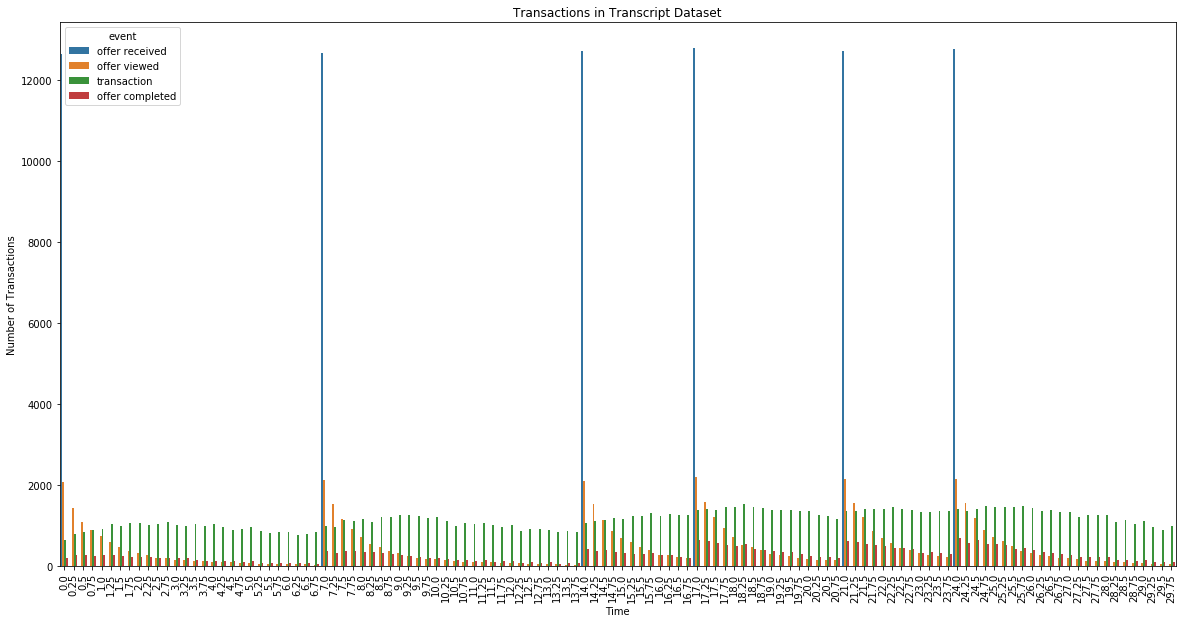

In [4]:
#what's the distribution of the time value - how are offers distributed
plt.figure(figsize=(20,10))
sns.countplot(transcript.time/24, hue = transcript.event)
plt.xticks(rotation=90)
plt.title('Transactions in Transcript Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

In [5]:
# are offers at distinct times?
transcript[transcript.event == 'offer received'].time.value_counts()
# yes

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [6]:
# process impact of offers on individual spending
offer_impact = calculate_offer_impact(transcript, portfolio)
offer_impact.head(20)

Importing Previously Saved Dataset


person                             offer  \
0   d2482847c5b34aefaa39f55afc669d0f  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1   d2482847c5b34aefaa39f55afc669d0f  2298d6c36e964ae4a3e7e9706d1fb8c2   
2   402c544727ae422bbe2d1ad7efcaf49a  ae264e3637204a6fb9bb56bc8210ddfd   
3   6ef8a5ad165246d681f4399437fa2ab9  4d5c57ea9a6940dd891ad53e9dbe8da0   
4   6ef8a5ad165246d681f4399437fa2ab9  ae264e3637204a6fb9bb56bc8210ddfd   
5   6ef8a5ad165246d681f4399437fa2ab9  2298d6c36e964ae4a3e7e9706d1fb8c2   
6   9be805c5483648bdb194ecc63b502f4c  5a8bc65990b245e5a138643cd4eb9837   
7   f97254f804b149e68d6c4b3da75e060f  2906b810c7d4411798c6938adc9daaa5   
8   c7a6bf2558554bf5954ed506eb3968f1  ae264e3637204a6fb9bb56bc8210ddfd   
9   c7a6bf2558554bf5954ed506eb3968f1  f19421c1d4aa40978ebb69ca19b0e20d   
10  ab2dfcc6a76844a9a5a37d9d93a74ff7  2298d6c36e964ae4a3e7e9706d1fb8c2   
11  a3fb80657b0b48018345c415a72838b4  fafdcd668e3743c1bb461111dcafc2a4   
12  aada49f7ba684e51a630dbf5d2a12b6c  4d5c57ea9a6940dd891ad53e9dbe8da0   
13  aada49f7ba684e51a630dbf5d2a12b6c  fafdcd668e3743c1bb461111dcafc2a4   
14  aada49f7ba684e51a630dbf5d2a12b6c  2298d6c36e964ae4a3e7e9706d1fb8c2   
15  aada49f7ba684e51a630dbf5d2a12b6c  fafdcd668e3743c1bb461111dcafc2a4   
16  75c6aaed068b47968b4916342184b0dd  fafdcd668e3743c1bb461111dcafc2a4   
17  a5c15f41f7ed4c3289ebb87b23bb1fff  3f207df678b143eea3cee63160fa8bed   
18  a5c15f41f7ed4c3289ebb87b23bb1fff  4d5c57ea9a6940dd891ad53e9dbe8da0   
19  a5c15f41f7ed4c3289ebb87b23bb1fff  fafdcd668e3743c1bb461111dcafc2a4   

    offer_daily_spend  no_influence_avg_daily_spend        lift  
0            1.414167                      1.226250    1.153245  
1            1.162000                      1.226250    0.947604  
2            1.164500                      8.073333    0.144240  
3            5.870000                      8.395882    0.699152  
4            4.145000                      8.395882    0.493694  
5            1.642000                      8.395882    0.195572  
6            0.620000                      0.568824    1.089969  
7            0.920000                      2.947500    0.312129  
8            0.668571                      2.900000    0.230542  
9            0.510000                      2.900000    0.175862  
10           0.682500                      0.004167  163.800000  
11           2.505333                      7.737500    0.323791  
12           2.260000                      0.462500    4.886486  
13           0.110000                      0.462500    0.237838  
14           0.727000                      0.462500    1.571892  
15           2.290000                      0.462500    4.951351  
16           0.228571                      0.237143    0.963855  
17          11.405000                      6.616316    1.723769  
18           3.472857                      6.616316    0.524893  
19           5.560000                      6.616316    0.840347

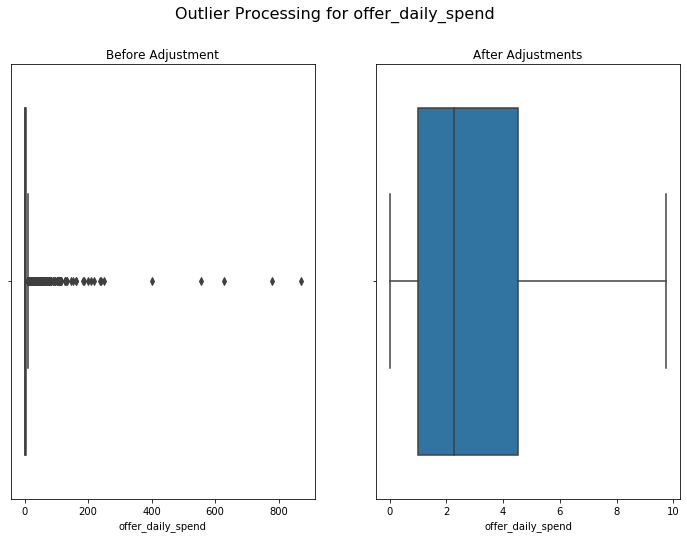

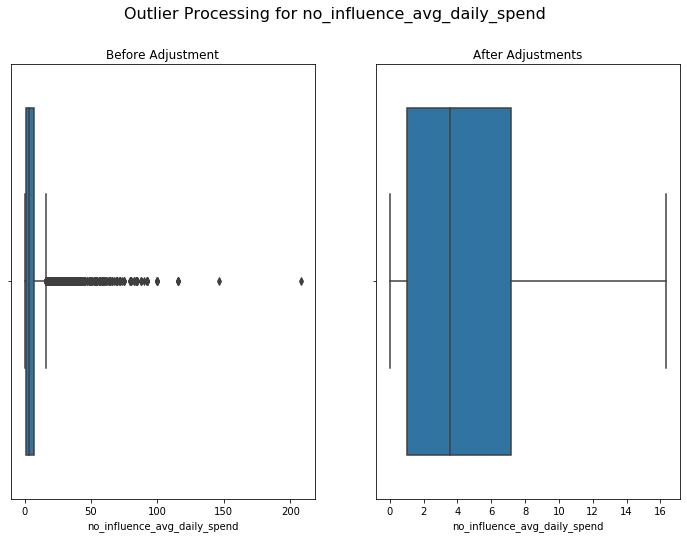

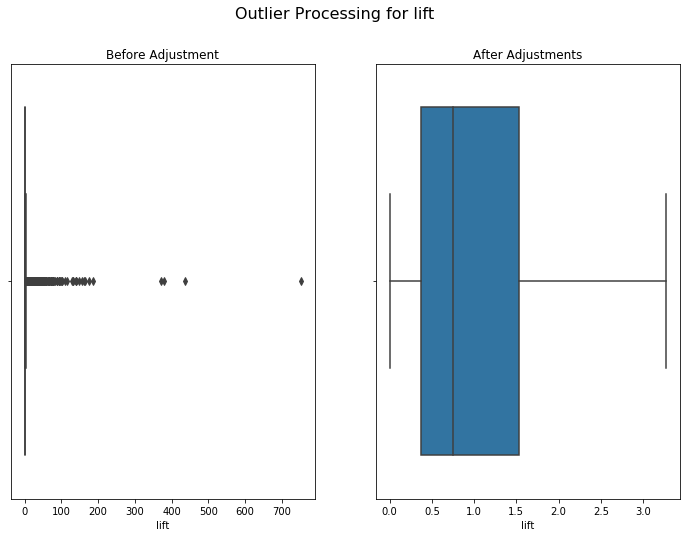

In [7]:
for col in ['offer_daily_spend', 'no_influence_avg_daily_spend','lift']:
    offer_impact[col] = IQR_adjustment(offer_impact[col],col)
    

In [8]:
# check impact of offers for one individual
tmp = offer_impact.loc[offer_impact.person =='a5c15f41f7ed4c3289ebb87b23bb1fff']
tmp

person                             offer  \
17  a5c15f41f7ed4c3289ebb87b23bb1fff  3f207df678b143eea3cee63160fa8bed   
18  a5c15f41f7ed4c3289ebb87b23bb1fff  4d5c57ea9a6940dd891ad53e9dbe8da0   
19  a5c15f41f7ed4c3289ebb87b23bb1fff  fafdcd668e3743c1bb461111dcafc2a4   

    offer_daily_spend  no_influence_avg_daily_spend      lift  
17           9.755625                      6.616316  1.723769  
18           3.472857                      6.616316  0.524893  
19           5.560000                      6.616316  0.840347

This is a good indication of two offers having a negative impact, while one offer has a significant impact (almost doubling spending)

In [9]:
# which offers was this person exposed to? 
tmp.loc[:,['offer','lift']].merge(portfolio,how = 'left',left_on = 'offer',right_on = 'id')

offer      lift  reward  difficulty  duration  \
0  3f207df678b143eea3cee63160fa8bed  1.723769       0           0         4   
1  4d5c57ea9a6940dd891ad53e9dbe8da0  0.524893      10          10         5   
2  fafdcd668e3743c1bb461111dcafc2a4  0.840347       2          10        10   

                                 id  social  web  mobile  email  discount  \
0  3f207df678b143eea3cee63160fa8bed       0    1       1      1         0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0       1    1       1      1         0   
2  fafdcd668e3743c1bb461111dcafc2a4       1    1       1      1         1   

   bogo  informational  
0     0              1  
1     1              0  
2     0              0

it looks as though the two offers with low lift were high difficulty items. Lets look at a correlation plot for lift relative to portfolio metrics

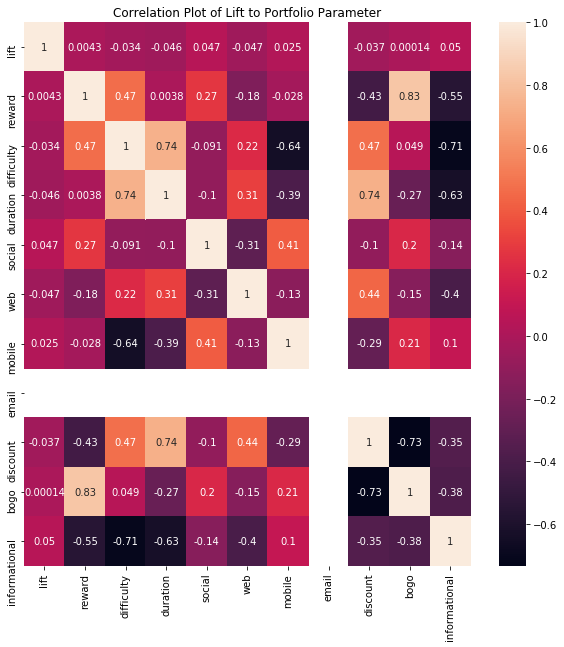

In [10]:
df_tmp = offer_impact.merge(portfolio,how = 'left',left_on = 'offer',right_on = 'id')
df_tmp.drop(columns = ['person','offer','id', 'offer_daily_spend','no_influence_avg_daily_spend'],inplace=True)
plt.figure(figsize=(10,10))
sns.heatmap(df_tmp.corr(), annot=True)
plt.title('Correlation Plot of Lift to Portfolio Parameter')
plt.show()

As can be seen from the correlation plot above, Lift is not highly corelated to any indivudual portfolio parameter. That being said, it can be seen that (as expected) higher difficulty is a deterrant, and also social distribution drives is more successful at converting sales than web.


### Profile Dataset

In [11]:
profile = clean_profile(profile)

Importing Previously Saved Dataset


In [12]:
profile.head()

gender   age    income  months_since_join                                id
0     0.0  54.4   47000.0          39.100000  68be06ca386d4c31939f3a4f0e3dd783
1     0.0  55.0  112000.0          34.000000  0610b486422d4921ae7d2bf64640c50b
2     1.0  58.6   58800.0          21.933333  38fe809add3b4fcf9315a9694bb96ff5
3     0.0  75.0  100000.0          36.233333  78afa995795e4d85b5d9ceeca43f5fef
4     0.0  51.0   64600.0          33.333333  a03223e636434f42ac4c3df47e8bac43

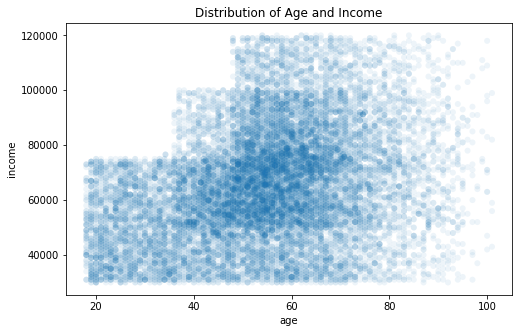

In [13]:
# Plot distribution of Age and Income (Looks Synthetic)
plt.figure(figsize=(8,5))
sns.scatterplot(x='age',y='income', data = profile, alpha = 0.08,edgecolor='none')
plt.title('Distribution of Age and Income')
plt.show()

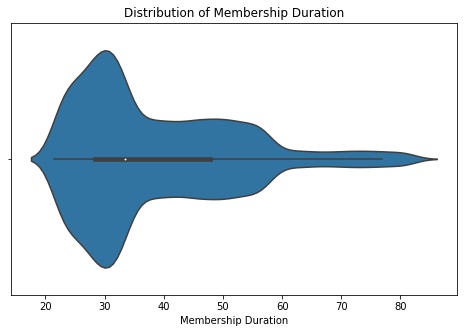

In [14]:
# plot distribution of Membership Duration
plt.figure(figsize=(8,5))
sns.violinplot(profile.months_since_join)
plt.title('Distribution of Membership Duration')
plt.xlabel('Membership Duration')
plt.show()

## Train and Test Models

In another script, I attempted to train regression models using pipelines and GridSearch params, but I attained a low accuracy result. With more time, I would do more pre-processing and feature engineering to establish a higher accuracy model. 

Instead, the below models are a classifier and Logistic Regression for whether or not the offer was successful in increasing someone's spending by some threshold beyond their uninfluenced spending (default 1.25x). Both models were trained to establish feature importance (from Classifier) as well as resultant direction of incluence (Logistic Regression).

This model is meant to support tuning new offers to individuals by testing what types of offers would be successful given information about the individual.

In [15]:
# prep dataset for modeling
model_data = prep_for_binary_model(offer_impact, profile, portfolio, lift_threshold = 1.25)
model_data.head()

no_influence_avg_daily_spend      lift  gender   age   income  \
0                      1.226250  1.153245     1.0  67.0  43000.0   
1                      5.528636  0.195949     1.0  27.0  52000.0   
2                      4.144444  0.455630     1.0  27.0  59000.0   
3                      4.955000  0.668819     1.0  84.0  52000.0   
4                     11.676250  0.499304     0.0  83.0  93000.0   

   months_since_join  reward  difficulty  duration  social  web  mobile  \
0          46.433333       5           5         7       0    1       1   
1          26.433333       5           5         7       0    1       1   
2          54.633333       5           5         7       0    1       1   
3          51.300000       5           5         7       0    1       1   
4          46.233333       5           5         7       0    1       1   

   email  discount  bogo  informational  binary_lift  
0      1         0     1              0        False  
1      1         0     1              0        False  
2      1         0     1              0        False  
3      1         0     1              0        False  
4      1         0     1              0        False

In [17]:
# build and train models
X = model_data.drop(columns=['lift', 'binary_lift'])
y = model_data.binary_lift

print('----XGB Classifier----')
classifier, cl_accuracy = build_train_classifier(X,y, import_model = False, run_gridsearch = False)

print('\n ----Logistic Regression----')
log_regression, lr_accuracy = build_train_log_regression(X,y, import_model = False, run_gridsearch = False)

print('\n ----Accuracy----')
print('Accuracy of XGB Classifier is: {}%'.format(round(cl_accuracy*100,1)))
print('Accuracy of Logistic Regression Model is: {}%'.format(round(lr_accuracy*100,1)))


----XGB Classifier----
Building Model
Training Model
Evaluating on Test Data
Saving Model

 ----Logistic Regression----
Building Model
Training Model
Evaluating on Test Data
Saving Model

 ----Accuracy----
Accuracy of XGB Classifier is: 76.0%
Accuracy of Logistic Regression Model is: 72.6%


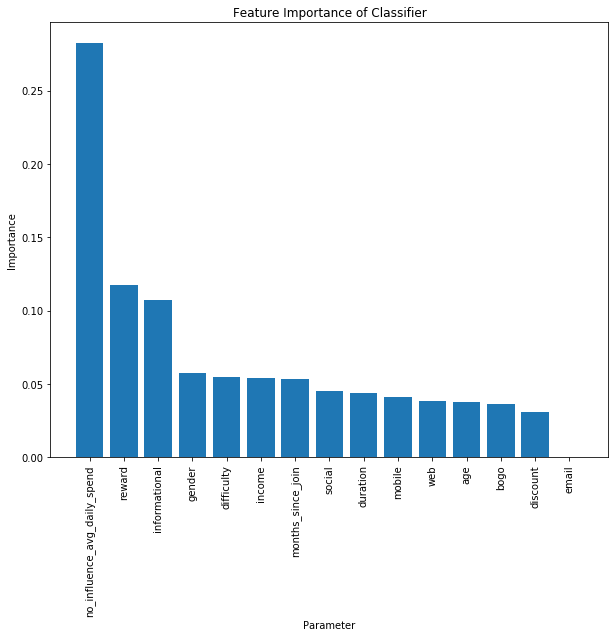

In [22]:
# Plot Feature Importance
feature_importance = pd.Series(index=X.columns,data = classifier.feature_importances_)
feature_importance.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(10,8))
plt.bar(x=feature_importance.index, height = feature_importance)
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.xlabel('Parameter')
plt.title('Feature Importance of Classifier')
plt.show()

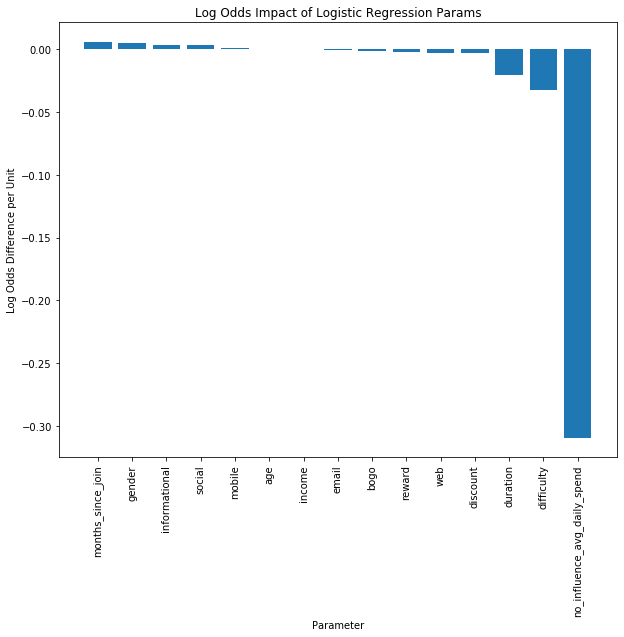

In [24]:
coef = pd.Series(index=X.columns,data = log_regression.coef_[0])
coef.sort_values(ascending=False,inplace=True)

plt.figure(figsize=(10,8))
plt.bar(x=coef.index, height = coef)
plt.xticks(rotation = 90)
plt.ylabel('Log Odds Difference per Unit')
plt.xlabel('Parameter')
plt.title('Log Odds Impact of Logistic Regression Params')
plt.show()